In [31]:
pip install faker

In [54]:
import requests
import pandas as pd
import random
from datetime import datetime, timedelta
from faker import Faker

fake = Faker()

# Step 1: Get users from RandomUser API
def fetch_users(n=50):
    url = f"https://randomuser.me/api/?results={n}"
    response = requests.get(url)
    data = response.json()
    users = []

    for user in data['results']:
        users.append({
            "user_id": user['login']['uuid'],
            "name": f"{user['name']['first']} {user['name']['last']}",
            "age": user['dob']['age'],
            "gender": user['gender'],
            "country": user['location']['country'],
            "email": user['email']
        })
    return pd.DataFrame(users)

# Step 2: Get products from Fake Store API
def fetch_products():
    url = "https://fakestoreapi.com/products"
    response = requests.get(url)
    data = response.json()
    return pd.DataFrame(data)

# Step 3: Generate transactions
def generate_transactions(users_df, products_df, n_transactions=200):
    transactions = []

    for _ in range(n_transactions):
        user = users_df.sample(1).iloc[0]
        product = products_df.sample(1).iloc[0]
        base_time = datetime.now() - timedelta(days=random.randint(1, 30))
        transaction_time = base_time + timedelta(minutes=random.randint(0, 1440))

        amount = round(product['price'] * random.uniform(0.9, 1.5), 2)
        payment_method = random.choice(['UPI', 'Credit Card', 'Debit Card', 'Netbanking', 'Unknown'])
        device = random.choice(['iPhone 13', 'Android Samsung', 'Windows PC', 'Macbook', 'Unknown'])
        is_fraud = 0

        # Simulate simple fraud logic
        if amount > 500 or payment_method == 'Unknown' or device == 'Unknown':
            is_fraud = 1

        transactions.append({
            "user_id": user['user_id'],
            "name": user['name'],
            "age": user['age'],
            "country": user['country'],
            "email": user['email'],
            "gender": user['gender'],
            "product": product['title'],
            "category": product['category'],
            "amount": amount,
            "payment_method": payment_method,
            "device": device,
            "transaction_time": transaction_time.strftime("%Y-%m-%d %H:%M:%S"),
            "is_fraud": is_fraud
        })

    return pd.DataFrame(transactions)

# Main workflow
users_df = fetch_users(100)
products_df = fetch_products()
transactions_df = generate_transactions(users_df, products_df, n_transactions=500)

# Save to CSV
transactions_df.to_csv("fraud_detection_dataset.csv", index=False)
print("✅ Dataset saved as 'fraud_detection_dataset.csv'")


✅ Dataset saved as 'fraud_detection_dataset.csv'


**Phase 1:** Exploratory Data Analysis (EDA)
Objective:

Understand the distribution, correlations, and patterns in the data.

Identify any imbalances or anomalies that might help you refine your fraud detection logic.

**Load the Data**

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("fraud_detection_dataset.csv")
print(df.head())


                                user_id                 name  age  \
0  2e2cbe69-45ec-41ed-90b0-deca703a5c1f          Runa Røsvik   78   
1  1b5dd9b6-2433-41e0-95ec-fe62c373d646        Maria Bennett   49   
2  fcdd86dd-9a73-4d3a-afda-561aae5ba86d  Ostromisl Ratushniy   54   
3  31ce0d2d-7dd5-424c-8264-af9744466d33    Alexander Vincent   58   
4  3a26d9d0-ea8e-4b27-b344-130f25ad3234       Julia Jennings   75   

       country                            email  gender  \
0       Norway          runa.rosvik@example.com  female   
1      Ireland        maria.bennett@example.com  female   
2      Ukraine  ostromisl.ratushniy@example.com    male   
3  Switzerland    alexander.vincent@example.com    male   
4    Australia       julia.jennings@example.com  female   

                                             product          category  \
0  Silicon Power 256GB SSD 3D NAND A55 SLC Cache ...       electronics   
1         DANVOUY Womens T Shirt Casual Cotton Short  women's clothing   
2       

**Basic Statistics & Data Info**

In [56]:
print(df.info())
print(df.describe())
print(df['is_fraud'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           500 non-null    object 
 1   name              500 non-null    object 
 2   age               500 non-null    int64  
 3   country           500 non-null    object 
 4   email             500 non-null    object 
 5   gender            500 non-null    object 
 6   product           500 non-null    object 
 7   category          500 non-null    object 
 8   amount            500 non-null    float64
 9   payment_method    500 non-null    object 
 10  device            500 non-null    object 
 11  transaction_time  500 non-null    object 
 12  is_fraud          500 non-null    int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 50.9+ KB
None
              age       amount    is_fraud
count  500.000000   500.000000  500.000000
mean    52.024000   182.452380    0

**Distribution of Transaction Amounts**

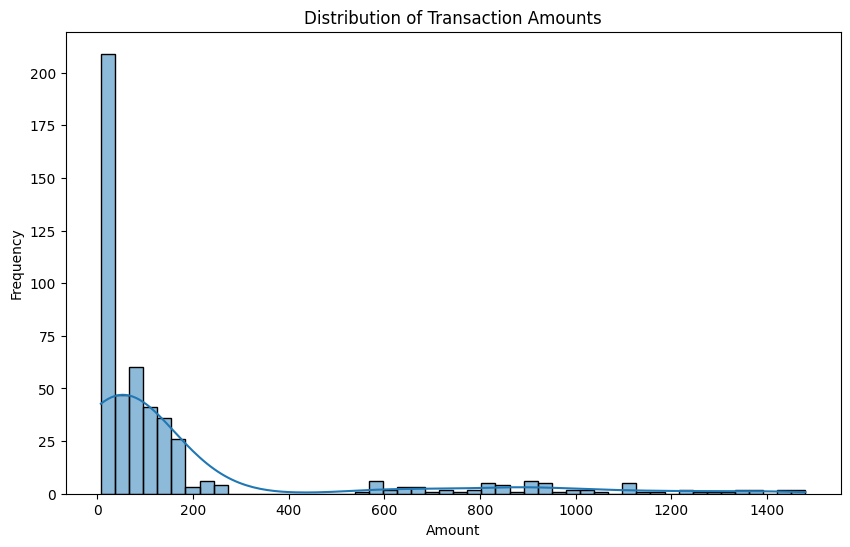

In [57]:
plt.figure(figsize=(10, 6))
sns.histplot(df['amount'], bins=50, kde=True)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()


**Fraud vs. Non-Fraud Analysis**

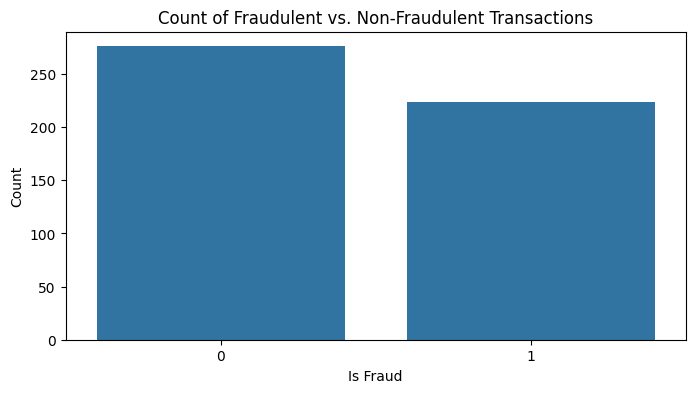

In [58]:
plt.figure(figsize=(8, 4))
sns.countplot(x='is_fraud', data=df)
plt.title("Count of Fraudulent vs. Non-Fraudulent Transactions")
plt.xlabel("Is Fraud")
plt.ylabel("Count")
plt.show()


**Correlation Heatmap**

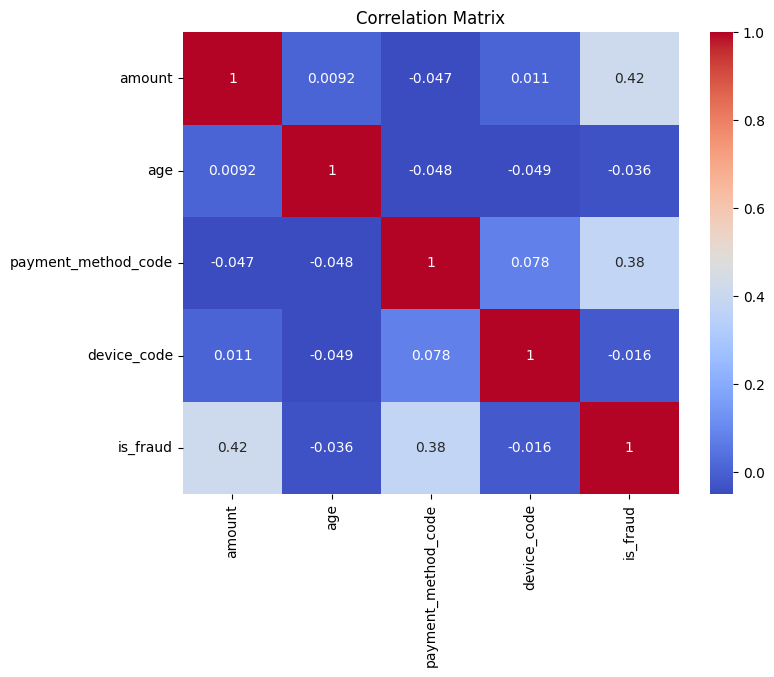

In [59]:
# For simplicity, let’s encode 'payment_method' and 'device'
df_encoded = df.copy()
df_encoded['payment_method_code'] = df_encoded['payment_method'].astype('category').cat.codes
df_encoded['device_code'] = df_encoded['device'].astype('category').cat.codes

# Create a correlation matrix
corr_matrix = df_encoded[['amount', 'age', 'payment_method_code', 'device_code', 'is_fraud']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


**Time-Based Trends**

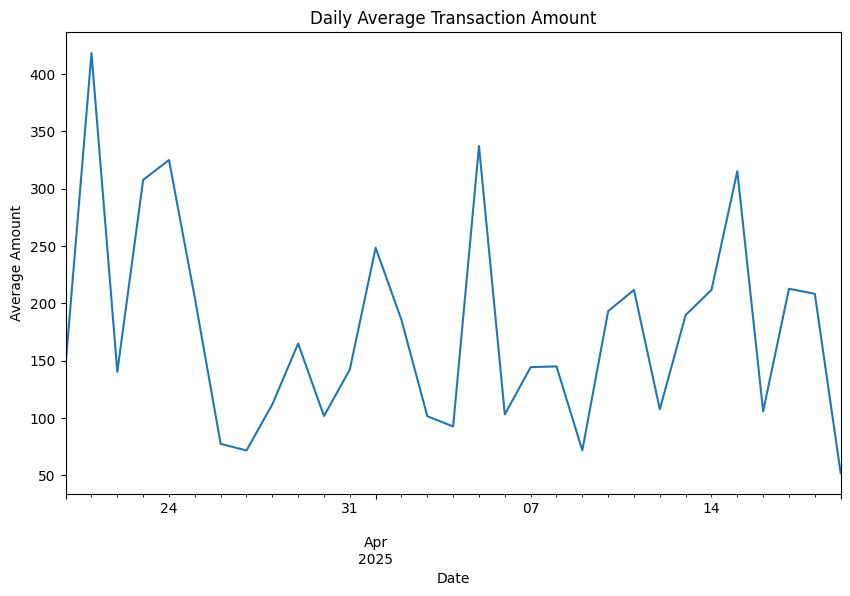

In [60]:
df['transaction_time'] = pd.to_datetime(df['transaction_time'])
df.set_index('transaction_time', inplace=True)

plt.figure(figsize=(10, 6))
df['amount'].resample('D').mean().plot()
plt.title("Daily Average Transaction Amount")
plt.xlabel("Date")
plt.ylabel("Average Amount")
plt.show()


**Phase 2: Model Building for Fraud Detection**

**Preserved Categorical Columns**

In [99]:
import pandas as pd
import random
from datetime import datetime
from faker import Faker
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Step 1: Generate original clean data
fake = Faker()

def generate_fraud_data(num_records=10000):
    data = []
    payment_methods = ['Visa', 'MasterCard', 'PayPal', 'Crypto']
    devices = ['Mobile', 'Desktop']
    countries = ['USA', 'UK', 'India', 'Germany', 'Brazil', 'Russia', 'China']

    for _ in range(num_records):
        user_id = random.randint(1000, 9999)
        age = random.randint(18, 75)  # <-- Make sure this line is here
        transaction_time = fake.date_time_between(start_date='-1y', end_date='now')
        amount = round(random.uniform(5, 5000), 2)
        payment_method = random.choice(payment_methods)
        device = random.choice(devices)
        country = random.choice(countries)
        is_fraud = int(random.choices([0, 1], weights=[0.97, 0.03])[0])  # 3% fraud rate

        data.append({
            'user_id': user_id,
            'age': age,
            'transaction_time': transaction_time,
            'amount': amount,
            'payment_method': payment_method,
            'device': device,
            'country': country,
            'is_fraud': is_fraud
        })

    return pd.DataFrame(data)


# Generate & save clean original data
df = generate_fraud_data()
df.to_csv("actual_fraud_data.csv", index=False)

# Step 2: Encode for modeling
df_encoded = pd.get_dummies(df.drop(columns=['transaction_time']), drop_first=True)

# Split
X = df_encoded.drop(columns=['is_fraud'])
y = df_encoded['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 3: Predict and join with clean original df
fraud_prob = model.predict_proba(X_test)[:, 1]

results_df = X_test.copy()
results_df['fraud_probability'] = fraud_prob
results_df['actual_is_fraud'] = y_test.values
results_df['risk_score'] = results_df['fraud_probability'] * results_df['amount']

# Pull human-readable columns from original df using same indices
human_fields = df.loc[X_test.index, ['user_id','age','transaction_time', 'payment_method', 'device', 'country']].reset_index(drop=True)

# Final merge
final_dashboard_df = pd.concat([results_df.reset_index(drop=True), human_fields], axis=1)

# Export final clean dashboard data
final_dashboard_df.to_csv("fraud_dashboard_data.csv", index=False)
print("✅ Clean dashboard dataset ready as 'fraud_dashboard_data.csv'")


✅ Clean dashboard dataset ready as 'fraud_dashboard_data.csv'


**Feature Importance**

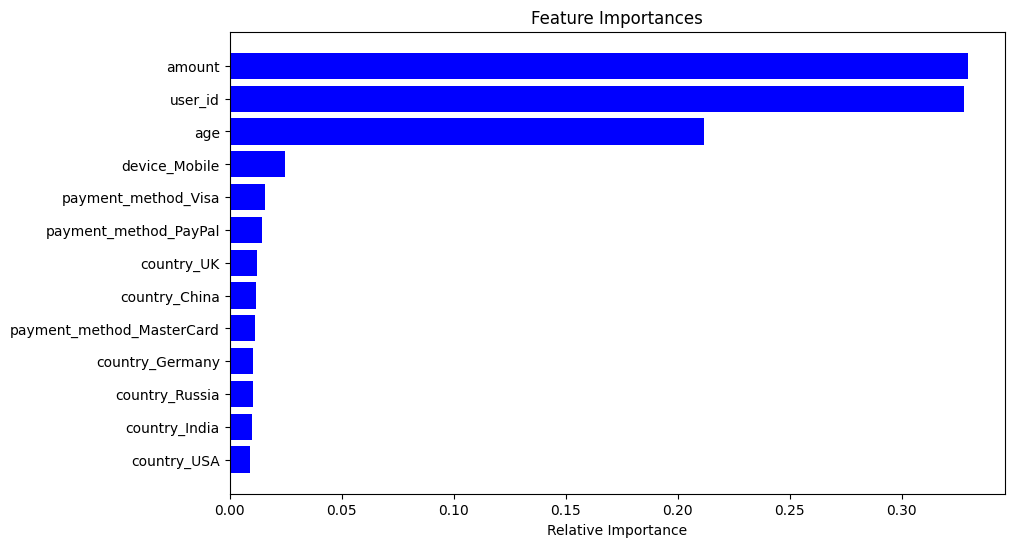

In [100]:
import numpy as np
importances = model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()


**Run Isolation Forest**

In [104]:
from sklearn.ensemble import IsolationForest

# Use only numeric columns for anomaly detection
features_for_anomaly = df_encoded[['amount', 'age']]  # Or more features if needed

# Fit the Isolation Forest
iso = IsolationForest(contamination=0.03, random_state=42)
df_encoded['anomaly'] = iso.fit_predict(features_for_anomaly)

# Map anomaly column: -1 = anomaly, 1 = normal
df_encoded['anomaly'] = df_encoded['anomaly'].map({1: 0, -1: 1})


**Plot with Anomalies**

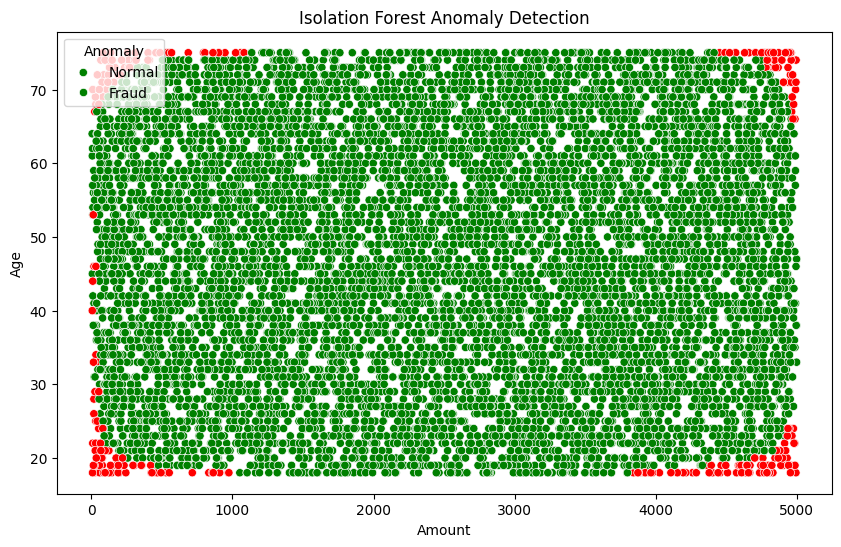

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='amount', y='age', hue='anomaly', data=df_encoded, palette=['green', 'red'])
plt.title("Isolation Forest Anomaly Detection")
plt.xlabel("Amount")
plt.ylabel("Age")
plt.legend(title="Anomaly", labels=["Normal", "Fraud"])
plt.show()


**Python Code to Generate Final CSV**

In [93]:
import pandas as pd
import random
from datetime import datetime
from faker import Faker
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Step 1: Generate original clean data
fake = Faker()

def generate_fraud_data(num_records=10000):
    data = []
    payment_methods = ['Visa', 'MasterCard', 'PayPal', 'Crypto']
    devices = ['Mobile', 'Desktop']
    countries = ['USA', 'UK', 'India', 'Germany', 'Brazil', 'Russia', 'China']

    for _ in range(num_records):
        user_id = random.randint(1000, 9999)
        transaction_time = fake.date_time_between(start_date='-1y', end_date='now')
        amount = round(random.uniform(5, 5000), 2)
        payment_method = random.choice(payment_methods)
        device = random.choice(devices)
        country = random.choice(countries)
        is_fraud = int(random.choices([0, 1], weights=[0.97, 0.03])[0])

        data.append({
            'user_id': user_id,
            'transaction_time': transaction_time,
            'amount': amount,
            'payment_method': payment_method,
            'device': device,
            'country': country,
            'is_fraud': is_fraud
        })

    return pd.DataFrame(data)

# Generate & save clean original data
df = generate_fraud_data()
df.to_csv("actual_fraud_data.csv", index=False)

# Step 2: Encode for modeling
df_encoded = pd.get_dummies(df.drop(columns=['transaction_time']), drop_first=True)

# Split
X = df_encoded.drop(columns=['is_fraud'])
y = df_encoded['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 3: Predict and join with clean original df
fraud_prob = model.predict_proba(X_test)[:, 1]

results_df = X_test.copy()
results_df['fraud_probability'] = fraud_prob
results_df['actual_is_fraud'] = y_test.values
results_df['risk_score'] = results_df['fraud_probability'] * results_df['amount']

# Pull human-readable columns from original df using same indices
human_fields = df.loc[X_test.index, ['user_id', 'transaction_time', 'payment_method', 'device', 'country']].reset_index(drop=True)

# Final merge
final_dashboard_df = pd.concat([results_df.reset_index(drop=True), human_fields], axis=1)

# Export final clean dashboard data
final_dashboard_df.to_csv("fraud_dashboard_data.csv", index=False)
print("✅ Clean dashboard dataset ready as 'fraud_dashboard_data.csv'")


✅ Clean dashboard dataset ready as 'fraud_dashboard_data.csv'
